### 0. Import

##### Setting Route

In [1]:
pwd

'/Users/kangjiwon/Desktop/LG Aimers/phase2_module/workspace/EDA'

In [2]:
cd ../../..

/Users/kangjiwon/Desktop/LG Aimers


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


##### Setting Module

In [3]:
# ! pip install associations

In [4]:
# pip install --upgrade pip

In [5]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import re, pickle
import warnings

In [6]:
from matplotlib import rc
from tqdm import tqdm
# from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from sklearn.metrics import precision_recall_curve

from euqipment import Enquipment

In [7]:
df = pd.read_csv('phase2_module/data/train.csv')
eq = Enquipment(df)

In [8]:
from phase2_module.src.utils.dataset import Data
from phase2_module.src.models.classification.models import Model
from phase2_module.src.base import BasePiepline
# from phase2_module.src.hyper_parameters.params_optimization import xgboost_opt, set_params_optimization_data
from phase2_module.src.utils.set_seed import seed_everything
from phase2_module.src.utils.top_score_instance import check_the_score

from phase2_module.src.utils.manage_pkl_files import PickleManager as pkl_manager
from phase2_module.src import preprocess
from sklearn.preprocessing import OneHotEncoder
from phase2_module.src.encoder.encoders import Encode
seed_everything()  # NOTE: default 42
_model = Model()

In [9]:
pkls = pkl_manager.map(pkl_manager.loads, pkl_manager.metadata_directory)

In [10]:
def set_up(mode= None):
    pd.set_option('display.max_columns', mode)
    pd.set_option('display.max_rows', 20000)
set_up()

In [11]:
warnings.filterwarnings('ignore')
%matplotlib inline

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('float_format', '{:.2f}'.format)

# pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 120)

##### Dataframe Load

In [12]:
raw_df = eq.raw_df()

In [13]:
# 동일한 column 제거
raw_df.drop('customer_country.1', axis=1, inplace=True)
# df_test.drop('customer_country.1', axis=1, inplace=True)

In [14]:
basic = preprocess.Basic

runtime_instance = {
    "Train": raw_df,
    "Instances":[
        {"instance": basic, "method": ['drop_duplicated'], "params": False},
    ]
}
raw_df = preprocess.runner('Train',**runtime_instance)

### 1. Data Analysis

#### **1.1 Columns Analysis**

##### **1.1.1 Column Description**

| Column Name           | Description                                                                                   |
|-----------------------|-----------------------------------------------------------------------------------------------|
| bant_submit           | MQL 구성 요소 중 Budget(예산), Title(고객의 직책/직급), Needs(요구사항), Timeline(희망 납기일)에 대한 값의 비율 |
| customer_country      | 고객의 국적                                                                                    |
| business_unit         | MQL 요청 상품에 대응되는 사업부                                                               |
| com_reg_ver_win_rate  | Vertical Level 1, business unit, region을 기준으로 oppty 비율을 계산                           |
| customer_idx          | 고객의 회사명                                                                                 |
| customer_type         | 고객 유형                                                                                    |
| enterprise            | Global 기업인지, Small/Medium 규모의 기업인지                                                |
| historical_existing_cnt | 이전에 Converted(영업 전환) 되었던 횟수                                                    |
| id_strategic_ver      | 특정 사업부(Business Unit), 특정 사업 영역(Vertical Level1)에 대해 가중치를 부여           |
| it_strategic_ver      | 특정 사업부(Business Unit), 특정 사업 영역(Vertical Level1)에 대해 가중치를 부여           |
| idit_strategic_ver    | Id_strategic_ver이나 it_strategic_ver 값 중 하나라도 1의 값을 가지면 1 값으로 표현             |
| customer_job          | 고객의 직업군                                                                                 |
| lead_desc_length      | 고객이 작성한 Lead Descriptoin 텍스트 총 길이                                                |
| inquiry_type          | 고객의 문의 유형                                                                              |
| product_category      | 요청 제품 카테고리                                                                            |
| product_subcategory   | 요청 제품 하위 카테고리                                                                       |
| product_modelname     | 요청 제품 모델명                                                                              |
| customer_country.1    | 담당 자사 법인명 기반의 지역 정보(대륙)                                                      |
| customer_position      | 고객의 회사 직책                                                                             |
| response_corporate     | 담당 자사 법인명                                                                             |
| expected_timeline      | 고객의 요청한 처리 일정                                                                      |
| ver_cus               | 특정 Vertical Level 1(사업영역)이면서 Customer_type(고객 유형)이 소비자(End-user)인 경우에 대한 가중치 |
| ver_pro               | 특정 Vertical Level 1(사업영역)이면서 특정 Product Category(제품 유형)인 경우에 대한 가중치           |
| ver_win_rate_x        | 전체 Lead 중에서 Vertical을 기준으로 Vertical 수 비율과 Vertical 별 Lead 수 대비 영업 전환 성공 비율 값을 곱한 값 |
| ver_win_ratio_per_bu  | 특정 Vertical Level1의 Business Unit 별 샘플 수 대비 영업 전환된 샘플 수의 비율을 계산       |
| business_area         | 고객의 사업 영역                                                                              |
| business_subarea      | 고객의 세부 사업 영역                                                                         |
| lead_owner            | 영업 담당자 이름                                                                              |
| is_converted          | 영업 성공 여부. True일 시 성공.                                                               |


##### **1.1.2 Column Information**

In [15]:
null_cols = raw_df.columns[raw_df.isnull().any()]

In [16]:
not_null_cols = set(raw_df.columns).difference(set(null_cols))

##### **1.1.3 Columns correlation**

In [17]:
# 크래머의 V 계수 계산 함수
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [18]:
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(raw_df)
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(raw_df.columns))

In [ ]:
hitmap = encoded_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

In [ ]:
# OneHotEncoder 객체 생성
encoder = OneHotEncoder()

# 데이터를 원핫인코딩
encoded_data = encoder.fit_transform(business_df)

# 인코딩된 데이터를 데이터프레임으로 변환
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(business_df.columns))

print("Encoded DataFrame:")
print(encoded_df)


In [ ]:
business_array = encoded_data.toarray().astype(int)
association(business_array, method="cramer")

In [ ]:
# correlation_matrix = cramers_v(business_df)



#### **1.2 Missing Value**

##### **1.2.1  Customer Type**

In [17]:
customer_cols = ['customer_job','customer_position','customer_type']
customer = preprocess.Customer
customer2 = preprocess.Customer2

In [18]:
runtime_instance = {
    "Train": raw_df,
    "Instances":[
        {"instance": customer, "method": ["apply"], "params": pkls.get("customer")},
        {"instance": customer2, "method": ['seniority_level', 'job_function', 'customer_type'], "params": pkls.get("customer2")},
    ]
}
raw_df = preprocess.runner('Train',**runtime_instance)

In [19]:
customer_cols = ['customer_job','customer_position','customer_type']
null_cols = eq.missing_columns(null_cols, customer_cols)

In [20]:
raw_df.drop(customer_cols, axis=1, inplace=True)

##### **1.2.2 Country Type**

In [21]:
country_cols = ['customer_country','response_corporate']
country = preprocess.Country

In [22]:
runtime_instance = {
    "Train": raw_df,
    "Instances":[
        {"instance": country, "method": ['apply'], "params": pkls.get("country")},
    ]
}
raw_df = preprocess.runner('Train',**runtime_instance)

In [23]:
country_cols = ['customer_country','response_corporate']
null_cols = eq.missing_columns(null_cols, country_cols)

In [24]:
raw_df.drop(country_cols, axis=1, inplace=True)

##### **1.2.3 Product Type**

In [25]:
product_cols = ['product_category','product_subcategory','product_modelname']
product_category = preprocess.ProductCategory

In [26]:
runtime_instance = {
    "Train": raw_df,
    "Instances":[
        {"instance": product_category, "method": ["product_categories", 'fill_odds'], "params": {**pkls.get("product_category"), **pkls.get("product_subcategory")}},
    ]
}
raw_df = preprocess.runner('Train',**runtime_instance)

In [27]:
product_cols = ['product_category','product_subcategory','product_modelname']
null_cols = eq.missing_columns(null_cols, product_cols)

In [28]:
raw_df.drop(product_cols, axis=1, inplace=True)

##### **1.1.4 Inquiry Type**

In [29]:
inquiry_cols = ['inquiry_type','expected_timeline']

In [30]:
inquiry = preprocess.Inquiry

In [31]:
runtime_instance = {
    "Train": raw_df,
    "Instances":[
        {"instance": inquiry, "method": ["apply"], "params": False},
    ]
}
raw_df = preprocess.runner('Train',**runtime_instance)

In [32]:
inquiry_cols = ['inquiry_type','expected_timeline']
null_cols = eq.missing_columns(null_cols, inquiry_cols)

In [33]:
raw_df.drop(inquiry_cols, axis=1, inplace=True)

-------

--------

##### **1.1.5 History Type**

In [45]:
history_cols = ['historical_existing_cnt']

In [46]:
relatived_cols = ['customer_idx', 'lead_owner', 'lead_desc_length', 'customer_type2', 'lead_desc_length','new_inquiry_type','new_expected_timeline']

In [47]:
raw_df['historical_existing_cnt'].fillna(0, inplace=True)
raw_df['historical_existing_cnt'].loc[raw_df['historical_existing_cnt']!=0]=1

In [48]:
# customer_idx에 따른 historical_existing_cnt의 mean
historical_dict = raw_df.groupby('new_customer_idx')['historical_existing_cnt'].mean().sort_values(ascending=False).to_dict()
raw_df['historical_existing_mean'] = raw_df['new_customer_idx'].map(historical_dict)

In [49]:
raw_df['lead_owner'].value_counts().sort_values(ascending=False)
raw_df.groupby('lead_owner')['historical_existing_mean'].value_counts().sort_values(ascending=False)

lead_owner  historical_existing_mean
175         0.93                        1983
23          0.93                         335
115         0.93                         322
174         0.06                         300
            0.93                         232
                                        ... 
1080        0.06                           1
            0.06                           1
            0.07                           1
            0.08                           1
            0.10                           1
Name: count, Length: 13396, dtype: int64

##### **1.1.6 Business Type**

In [50]:
business = preprocess.Business

In [51]:
runtime_instance = {
    "Train": raw_df,
    "Instances":[
        {"instance": business, "method": ["apply"], "params": pkls.get("business")},
    ]
}
raw_df = preprocess.runner('Train',**runtime_instance)

In [53]:
raw_df['business_area'].isna().sum()

0

In [54]:
raw_df['business_area'].value_counts()

business_area
corporate / office                26177
education                          8304
residential (home)                 7378
retail                             3853
hotel & accommodation              2859
factory                            2494
special purpose                    2029
hospital & health care             1082
government department               635
public facility                     503
transportation                      291
power plant / renewable energy      108
Space                                50
Name: count, dtype: int64

#### **1.3 Categorization**

In [38]:
categorization = preprocess.Categorization

##### **1.3.1 Cusomter_idx**

In [39]:
relatived_cols = ['is_converted', 'enterprise', 'business_area', 'lead_owner', 'country', 'continent', 'new_inquiry_type', 'customer_type2']

In [40]:
# raw_df['tmp_customer_idx'] = raw_df['customer_idx'].astype(str).str[:3]
# raw_df[['category_1','tmp_customer_idx']].value_counts().sort_index(ascending=False)
# len(raw_df['customer_idx'].astype(str).str[:2].value_counts().sort_values()) # Public Score : 0.41614906832298143
# len(raw_df['customer_idx'].value_counts().sort_values()) # Public Score : 0.41614906832298143

-> 다른 Column과 관련되어서 name되지 않음, 단순히 숫자로 범주화 진행

In [41]:
cat_customer_cols = ['customer_idx']

In [42]:
runtime_instance = {
    "Train": raw_df,
    "Instances":[
        {"instance": categorization, "method": ['cat_customer_idx'], "params": False},
    ]
}
raw_df = preprocess.runner('Train',**runtime_instance)

In [43]:
raw_df.drop(cat_customer_cols, axis=1, inplace=True)

##### **1.3.3 Enterprise**

In [44]:
runtime_instance = {
    "Train": raw_df,
    "Instances":[
        {"instance": categorization, "method": ['customer_idx_merge_enterprise'], "params": False},
    ]
}
raw_df = preprocess.runner('Train',**runtime_instance)

##### **1.3.2 Lead_owner**

In [41]:
not_null_cols

{'bant_submit',
 'business_unit',
 'customer_idx',
 'customer_position',
 'enterprise',
 'is_converted',
 'lead_desc_length',
 'lead_owner',
 'response_corporate'}

In [48]:
df[list(not_null_cols)].head()

,response_corporate,customer_position,bant_submit,is_converted,enterprise,lead_owner,lead_desc_length,customer_idx,business_unit
0,LGEPH,entry level,1.00,True,Enterprise,0,62,32160,AS
1,LGEPH,ceo/founder,1.00,True,Enterprise,1,96,23122,AS
2,LGEIL,partner,1.00,True,Enterprise,2,56,1755,AS
3,LGEIL,ceo/founder,1.00,True,Enterprise,3,44,4919,AS
4,LGEIL,partner,1.00,True,Enterprise,4,97,17126,AS


In [37]:
relatived_cols = ['is_converted', 'enterprise', 'business_area','customer_type2','category_1','new_inquiry_type', 'new_customer_idx']

In [41]:
raw_df.groupby('lead_owner')['enterprise'].value_counts().sort_index(ascending=False)

lead_owner  enterprise
1114        Enterprise       1
1111        Enterprise       1
1110        Enterprise       1
1109        Enterprise       1
1106        Enterprise       1
1105        Enterprise       1
1103        Enterprise       1
1102        Enterprise       1
1101        SMB              1
1099        Enterprise       1
1098        Enterprise       1
1096        Enterprise       2
1095        Enterprise       4
1094        Enterprise       1
1093        SMB              1
            Enterprise       2
1092        Enterprise       3
1091        Enterprise       1
1090        Enterprise       2
1089        Enterprise       1
1088        Enterprise       1
1086        Enterprise       1
1085        Enterprise       1
1084        Enterprise       1
1083        Enterprise       2
1082        Enterprise       1
1081        Enterprise       1
1080        SMB              1
            Enterprise       4
1079        Enterprise       1
1078        Enterprise       1
1077        Ente

In [434]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import decomposition

X_scaled = StandardScaler().fit_transform(X)

pca = decomposition.PCA(n_components=13)
pca_X = pca.fit_transform(X_scaled)

# 주성분으로 이루어진 데이터 프레임 구성
PAC_df = pd.DataFrame(data=pca_X)

In [435]:
import numpy as np
np.set_printoptions(precision=10, suppress=True)

In [436]:
pca.explained_variance_ratio_

array([0.1832867355, 0.101363386 , 0.088389455 , 0.0853946228,
       0.0777309572, 0.0770999322, 0.0742884259, 0.0703961381,
       0.0660020023, 0.0633528243, 0.0565128713, 0.0294426035,
       0.0267400461])

In [432]:
sum(pca.explained_variance_ratio_)

0.9438173504238992

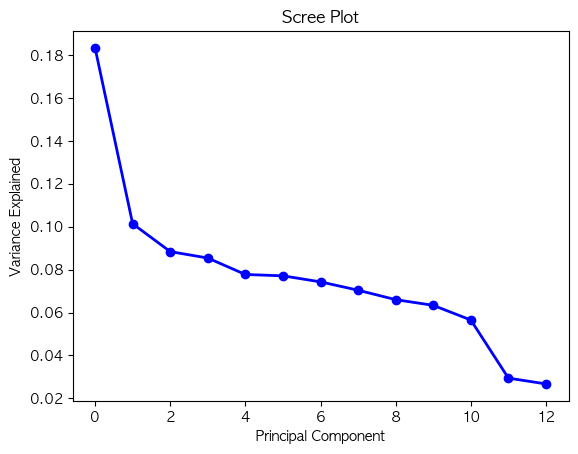

In [424]:
# Scree plot 통해 확인
PC_values = np.arange(pca.n_components_)
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()